In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

In [2]:
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

In [3]:
df = pd.read_csv('/content/sample_data/rice_final.csv', index_col=0)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [4]:
df = df.drop(['Temp'],axis=1)
df = df.drop(['Oil'],axis=1)
df = df.drop(['Sup'],axis=1)
df = df.drop(['Avg_Price'], axis=1)
df = df.drop(['Real_Price'], axis = 1)

df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns =['DayOfWeek'], prefix='W', drop_first=True)

df.tail()

,Date,Rain,Wind,sobimul,nongmul,Price,Produced,W_1,W_2,W_3,W_4
2390,2022-09-26,0.0,1.7,2.5,8.7,45957.0,5211037,0,0,0,0
2391,2022-09-27,0.0,1.6,2.5,8.7,45957.0,5211037,1,0,0,0
2392,2022-09-28,0.0,1.8,2.5,8.7,45586.0,5211037,0,1,0,0
2393,2022-09-29,0.0,1.4,2.5,8.7,45375.0,5211037,0,0,1,0
2394,2022-09-30,0.0,1.6,2.5,8.7,45375.0,5211037,0,0,0,1


In [5]:
from sklearn.preprocessing import MinMaxScaler
input_indicator = df.loc[:,['Rain', 'Wind', 'sobimul', 'nongmul', 'Produced', 'W_1', 'W_2', 'W_3', 'W_4']]
target_indicator = df.loc[:,['Price']].values[:]
scaler_input = MinMaxScaler()
scaler_target = MinMaxScaler()
scaled_input_indicator = scaler_input.fit_transform(input_indicator)
scaled_target_indicator = scaler_target.fit_transform(target_indicator) # 가격 관련 지표에 스케일링

x = np.concatenate((scaled_target_indicator, scaled_input_indicator), axis=1)
y = x[:, [0]]

print(x)
print(y.shape)

[[0.47995674 0.         0.61403509 ... 1.         0.         0.        ]
 [0.47995674 0.         0.36842105 ... 0.         1.         0.        ]
 [0.47995674 0.         0.19298246 ... 0.         0.         1.        ]
 ...
 [0.4558237  0.         0.19298246 ... 1.         0.         0.        ]
 [0.44869195 0.         0.12280702 ... 0.         1.         0.        ]
 [0.44869195 0.         0.15789474 ... 0.         0.         1.        ]]
(2395, 1)


In [73]:
# 21일치의 input으로 8일치의 output을 생산(API 문제상 당일날 input은 활용 불가능할 것으로 예상됨)
# 추후 train, validation, train set를 6년, 2년, 2년으로 나눠볼까 생각중, 지금은 many_to_many 코드 구현을 목표로 구현하지 않음
seq_length = 7
predict_day = 7
dataX = [] 
dataY = [] 
for i in range(0, int(len(y) - seq_length - predict_day)):
    _x = x[i : i + seq_length]
    _y = y[i + predict_day : i + seq_length + predict_day] 
    dataX.append(_x) 
    dataY.append(_y) 
print(len(dataX))
print(len(dataY))

2381
2381


In [74]:
# Train Set 생성, 추후 Validation, Test도 여기에다가 추가 예상됨, 또한 21의 배수로 설정해야 batch에서 오류가 발생하지 않음
train_size = 1428
validation_size = 476
test_size = 476

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
validX = np.array(dataX[train_size:train_size+validation_size])
validY = np.array(dataY[train_size:train_size+validation_size])
testX = np.array(dataX[train_size+validation_size:train_size+validation_size+test_size])
testY = np.array(dataY[train_size+validation_size:train_size+validation_size+test_size])

print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(1428, 7, 10)
(1428, 7, 1)
(476, 7, 10)
(476, 7, 1)
(476, 7, 10)
(476, 7, 1)


In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Activation
from tensorflow import keras

In [76]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [77]:
input_columns = 10 # 데이터 셋의 '열' 개수 (dataX) / dataset's columns (dataX)

model = Sequential()
model.add(LSTM(16, batch_input_shape=(7, 7, input_columns), return_sequences=True, stateful=True, dropout=0.01))
model.add(LSTM(16, return_sequences=True, stateful=True, dropout=0.01))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (7, 7, 16)                1728      
                                                                 
 lstm_3 (LSTM)               (7, 7, 16)                2112      
                                                                 
 dense_1 (Dense)             (7, 7, 1)                 17        
                                                                 
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________


In [78]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model-rice.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

In [79]:
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [80]:
custom_hist = CustomHistory()
custom_hist.init()

In [81]:
for epoch_idx in range(100):
  print('epochs:' + str(epoch_idx))
  hist = model.fit(trainX, trainY, validation_data=(validX, validY), epochs=1, batch_size=7, verbose=2, shuffle=False, callbacks=[checkpoint_cb, custom_hist, early_stopping_cb])
  model.reset_states()

epochs:0
204/204 - 4s - loss: 0.0061 - mae: 0.0532 - val_loss: 0.0273 - val_mae: 0.1215 - 4s/epoch - 20ms/step
epochs:1
204/204 - 1s - loss: 0.0079 - mae: 0.0611 - val_loss: 0.0252 - val_mae: 0.1361 - 937ms/epoch - 5ms/step
epochs:2
204/204 - 1s - loss: 0.0072 - mae: 0.0613 - val_loss: 0.0216 - val_mae: 0.1137 - 951ms/epoch - 5ms/step
epochs:3
204/204 - 1s - loss: 0.0073 - mae: 0.0625 - val_loss: 0.0192 - val_mae: 0.1142 - 946ms/epoch - 5ms/step
epochs:4
204/204 - 1s - loss: 0.0091 - mae: 0.0724 - val_loss: 0.0196 - val_mae: 0.1124 - 913ms/epoch - 4ms/step
epochs:5
204/204 - 1s - loss: 0.0084 - mae: 0.0699 - val_loss: 0.0264 - val_mae: 0.1371 - 1s/epoch - 5ms/step
epochs:6
204/204 - 1s - loss: 0.0079 - mae: 0.0689 - val_loss: 0.0319 - val_mae: 0.1460 - 926ms/epoch - 5ms/step
epochs:7
204/204 - 1s - loss: 0.0070 - mae: 0.0645 - val_loss: 0.0383 - val_mae: 0.1577 - 935ms/epoch - 5ms/step
epochs:8
204/204 - 1s - loss: 0.0062 - mae: 0.0601 - val_loss: 0.0475 - val_mae: 0.1771 - 929ms/epoch

In [82]:
a = 7

In [83]:
model.evaluate(trainX, trainY, batch_size = a)

204/204 [==============================] - 1s 3ms/step - loss: 0.0036 - mae: 0.0517


[0.003587626852095127, 0.051719535142183304]

In [84]:
print(custom_hist.train_loss)

[0.006081627681851387, 0.007855520583689213, 0.007230132818222046, 0.007308467291295528, 0.009099148213863373, 0.00836909655481577, 0.007922456599771976, 0.006993922404944897, 0.00620455713942647, 0.005906556732952595, 0.00565732829272747, 0.005553280469030142, 0.005279371980577707, 0.005120118148624897, 0.004799847025424242, 0.004527769982814789, 0.004167069680988789, 0.00389190879650414, 0.003755147336050868, 0.00351265468634665, 0.0034033996053040028, 0.003115946426987648, 0.003026262391358614, 0.002801780588924885, 0.002531156875193119, 0.002273417077958584, 0.0021240601781755686, 0.001960709225386381, 0.001923720701597631, 0.0018725879490375519, 0.0018234287854284048, 0.001745376968756318, 0.00175935635343194, 0.001693932106718421, 0.0017273899866268039, 0.001553934533149004, 0.0015069834189489484, 0.0015149882528930902, 0.0016249942127615213, 0.0015117238508537412, 0.0014950080076232553, 0.00141735072247684, 0.0014552169013768435, 0.0014126173919066787, 0.0016278947005048394, 0.0

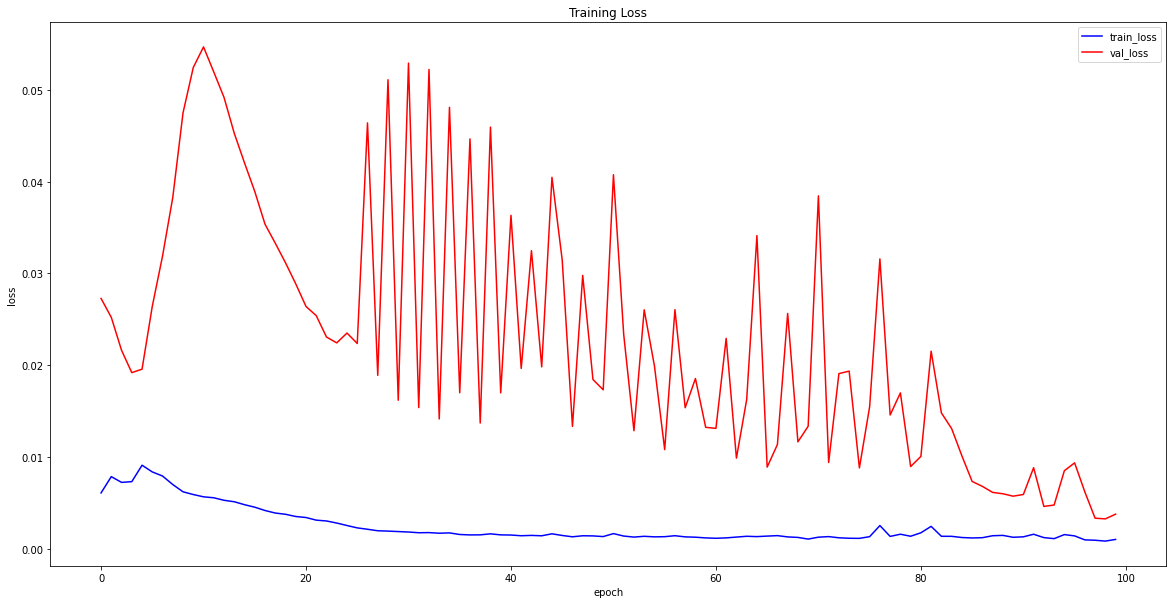

In [86]:
plt.figure(figsize=(20,10))
plt.plot(custom_hist.train_loss, color = 'blue', label = 'train_loss')
plt.plot(custom_hist.val_loss, color = 'red', label = 'val_loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [87]:
from keras.models import load_model
model = load_model('/content/best-model-rice.h5')

Train Data *평가*

In [88]:
model.evaluate(trainX, trainY, batch_size=a)

204/204 [==============================] - 1s 3ms/step - loss: 0.0020 - mae: 0.0366


[0.0020267509389668703, 0.036642685532569885]

In [89]:
predicted_price_train = model.predict(trainX, batch_size=a, verbose=1) 

204/204 [==============================] - 1s 2ms/step


In [90]:
trainY_test = np.delete(trainY, np.s_[1:a], axis=1)
predicted_price_train_test = np.delete(predicted_price_train, np.s_[1:a], axis=1)

trainY_test = np.reshape(trainY_test, (1428, 1))
predicted_price_train_test = np.reshape(predicted_price_train_test, (1428, 1))
print(trainY_test.shape)
print(predicted_price_train_test.shape)

(1428, 1)
(1428, 1)


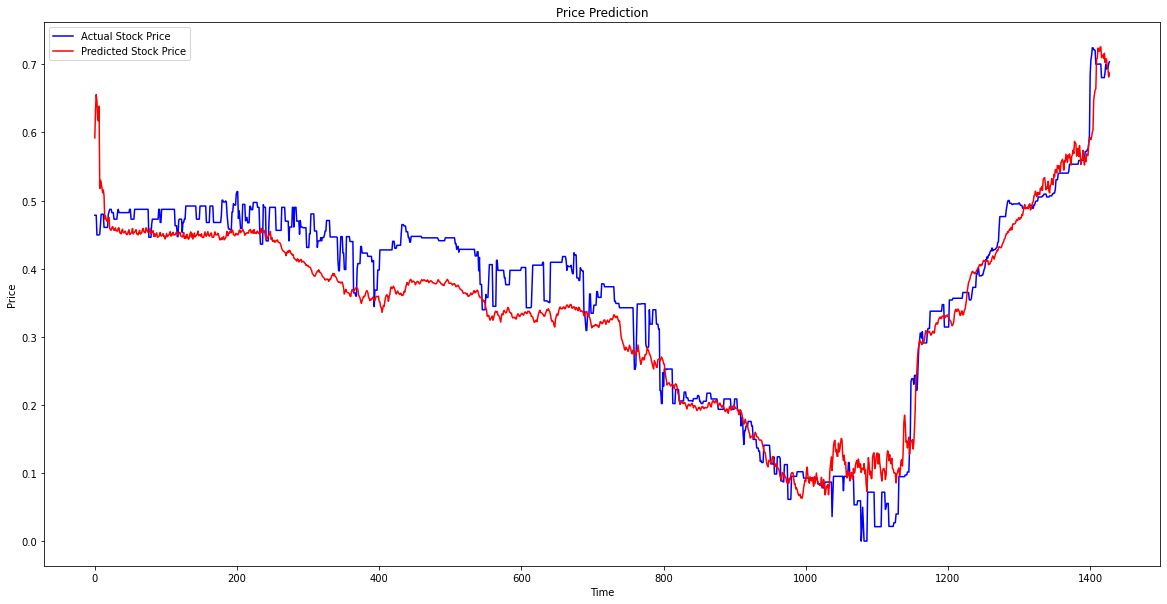

In [91]:
plt.figure(figsize=(20,10))
plt.plot(trainY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_train_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [92]:
predicted_price_train_test = np.reshape(predicted_price_train_test, (1428, ))
predicted_price_train_test = scaler_target.inverse_transform(predicted_price_train_test.reshape(-1,1))

print(predicted_price_train_test, predicted_price_train_test.shape)

trainY_test = scaler_target.inverse_transform(trainY_test.reshape(-1,1))

print(trainY_test, trainY_test.shape)

[[49616.582]
 [50856.023]
 [51500.36 ]
 ...
 [52645.78 ]
 [52262.97 ]
 [52439.465]] (1428, 1)
[[46257.]
 [46257.]
 [46257.]
 ...
 [52649.]
 [52836.]
 [52924.]] (1428, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


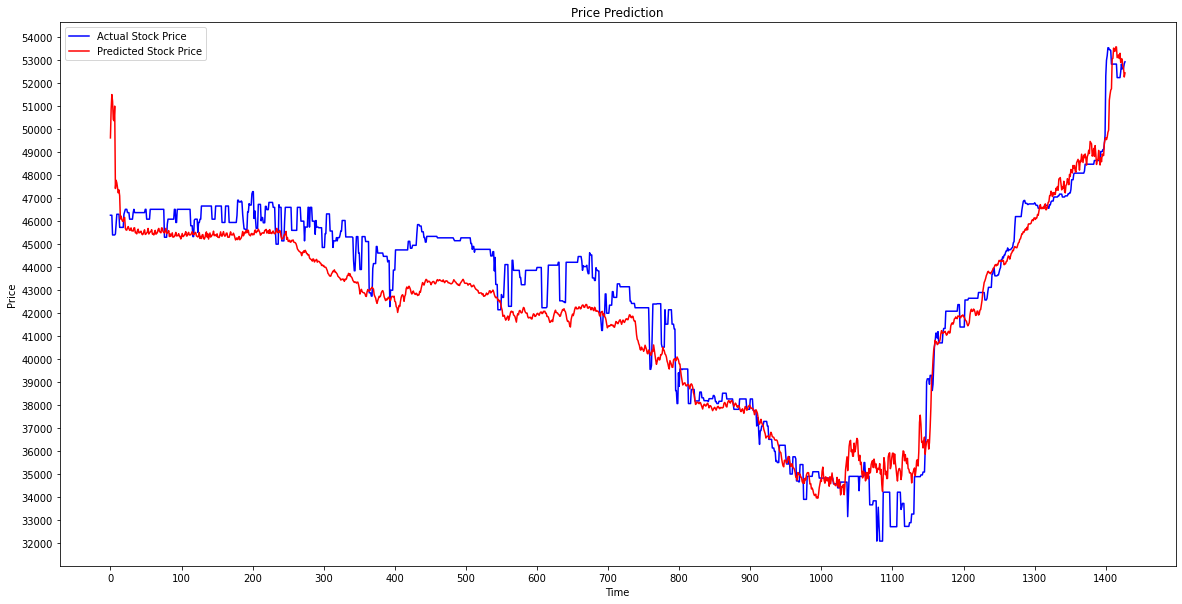

In [93]:
import matplotlib.ticker as ticker
plt.figure(figsize=(20,10))
plt.plot(trainY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_train_test, color = 'red', label = 'Predicted Stock Price')

ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))

plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [94]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(trainY_test, predicted_price_train_test) 
np.sqrt(MSE)

1377.1633734606867

In [95]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(trainY_test, predicted_price_train_test)

1106.9273787640057

Val Date 평가


In [96]:
model.evaluate(validX, validY, batch_size=a)

68/68 [==============================] - 0s 3ms/step - loss: 0.0033 - mae: 0.0426


[0.0032511954195797443, 0.042634036391973495]

In [97]:
predicted_price_valid = model.predict(validX, batch_size=a, verbose=1) 

68/68 [==============================] - 0s 2ms/step


(476, 1)
(476, 1)


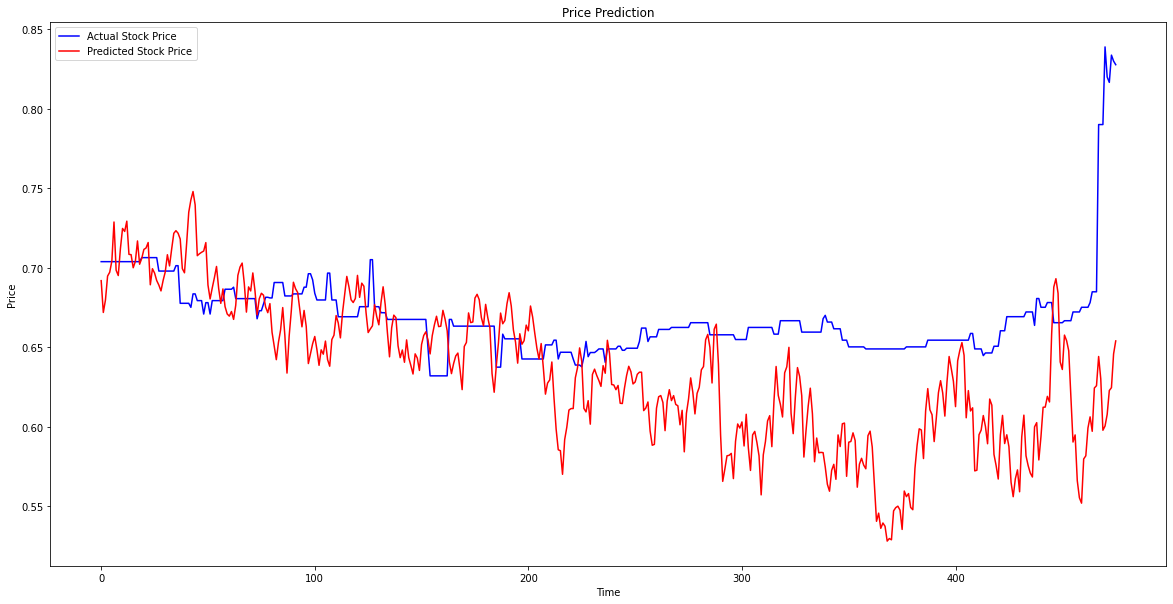

In [98]:
validY_test = np.delete(validY, np.s_[1:a], axis=1)
predicted_price_valid_test = np.delete(predicted_price_valid, np.s_[1:a], axis=1)

validY_test = np.reshape(validY_test, (476, 1))
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (476, 1))
print(validY_test.shape)
print(predicted_price_valid_test.shape)

plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [99]:
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (476, ))
predicted_price_valid_test = scaler_target.inverse_transform(predicted_price_valid_test.reshape(-1,1))

print(predicted_price_valid_test, predicted_price_valid_test.shape)

validY_test = scaler_target.inverse_transform(validY_test.reshape(-1,1))

print(validY_test, validY_test.shape)

[[52570.426]
 [51978.598]
 [52210.17 ]
 [52655.266]
 [52727.254]
 [52935.44 ]
 [53661.9  ]
 [52764.49 ]
 [52665.59 ]
 [53163.598]
 [53542.066]
 [53485.805]
 [53677.535]
 [53059.88 ]
 [53054.246]
 [52810.45 ]
 [52929.35 ]
 [53309.25 ]
 [52876.023]
 [52986.695]
 [53151.586]
 [53178.07 ]
 [53280.098]
 [52493.496]
 [52792.71 ]
 [52711.863]
 [52572.027]
 [52488.297]
 [52379.69 ]
 [52574.08 ]
 [52733.176]
 [53053.074]
 [52844.63 ]
 [53158.62 ]
 [53451.426]
 [53500.285]
 [53453.445]
 [53345.88 ]
 [52794.027]
 [52716.598]
 [53256.848]
 [53843.723]
 [54072.902]
 [54229.19 ]
 [53980.207]
 [53035.234]
 [53070.582]
 [53098.324]
 [53121.766]
 [53278.625]
 [52488.656]
 [52230.22 ]
 [52434.258]
 [52623.727]
 [52834.562]
 [52426.934]
 [52147.883]
 [52416.46 ]
 [52086.94 ]
 [51950.71 ]
 [51910.3  ]
 [51996.08 ]
 [51849.973]
 [52112.945]
 [52669.535]
 [52823.004]
 [52897.547]
 [52520.97 ]
 [51985.395]
 [52453.918]
 [52378.977]
 [52714.027]
 [52384.88 ]
 [51933.13 ]
 [52231.53 ]
 [52335.51 ]
 [52300.203]

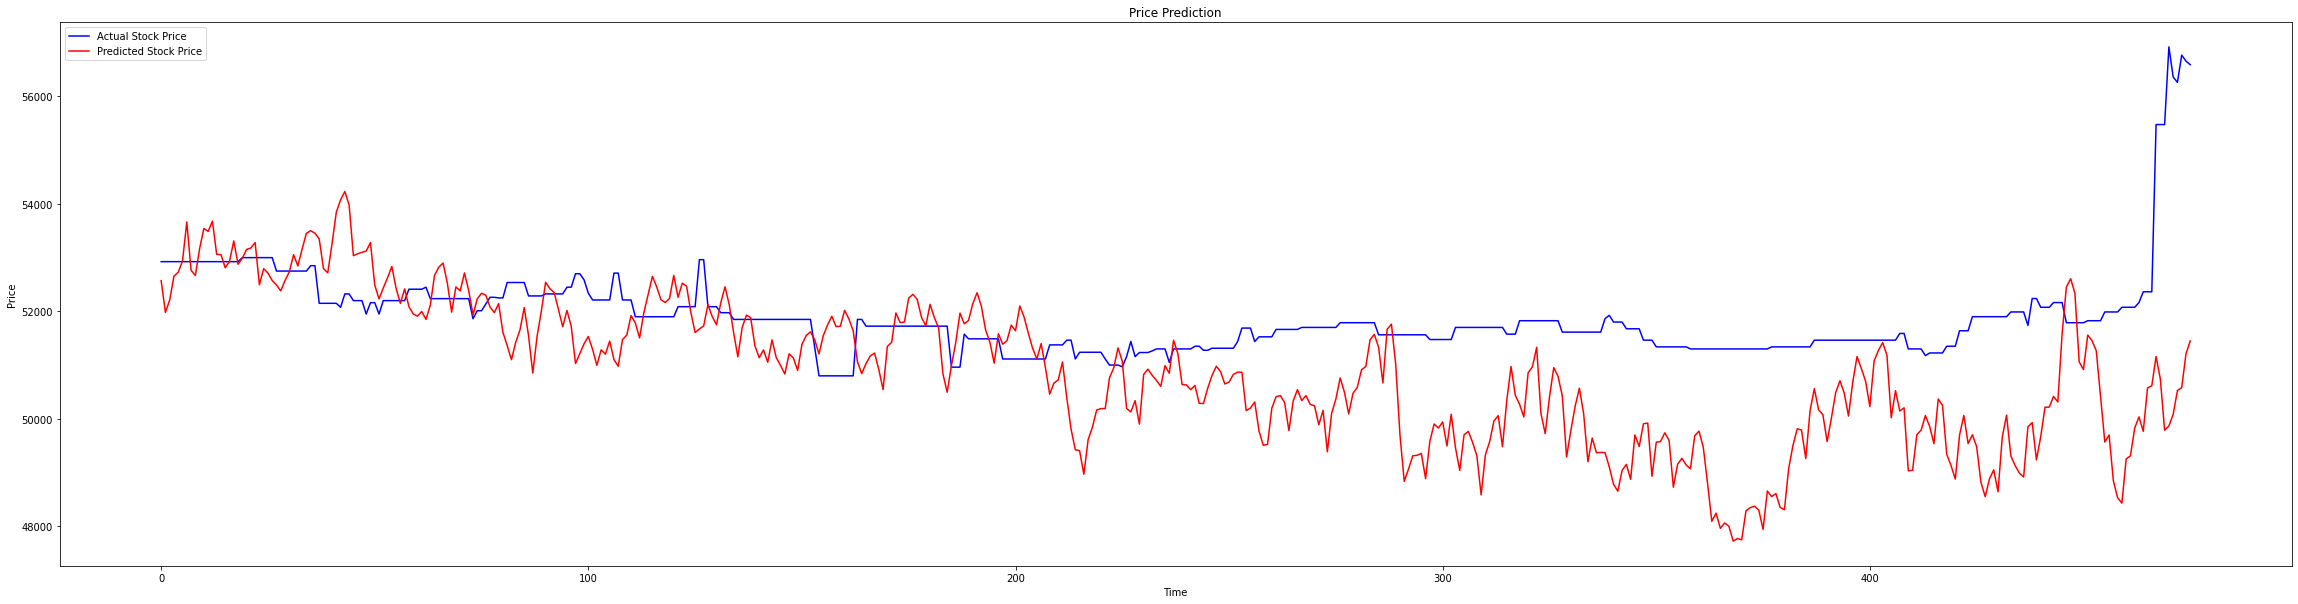

In [107]:
plt.figure(figsize=(40,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


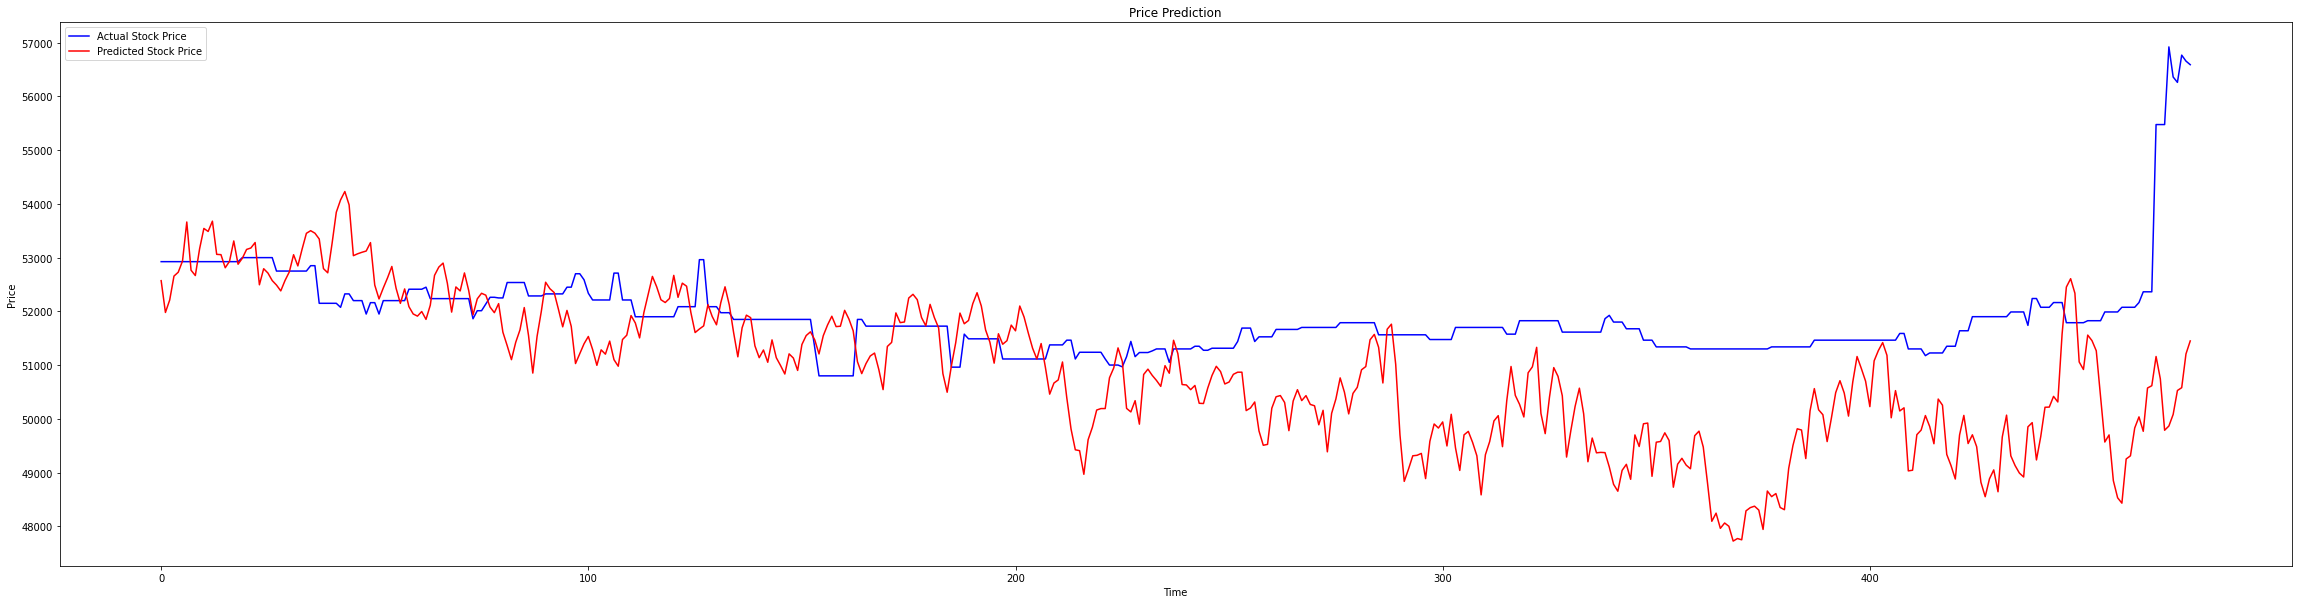

In [101]:
plt.figure(figsize=(40,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')

ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))

plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [102]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(validY_test, predicted_price_valid_test) 
np.sqrt(MSE)

1645.1194983626724

In [103]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validY_test, predicted_price_valid_test)

1236.5984604779412

Test Data 평가

In [104]:
model.evaluate(testX, testY, batch_size=a)

68/68 [==============================] - 0s 3ms/step - loss: 0.0046 - mae: 0.0558


[0.004631416406482458, 0.055820707231760025]

In [105]:
predicted_price_test = model.predict(testX, batch_size=a, verbose=1)

68/68 [==============================] - 0s 2ms/step


(476, 1)
(476, 1)


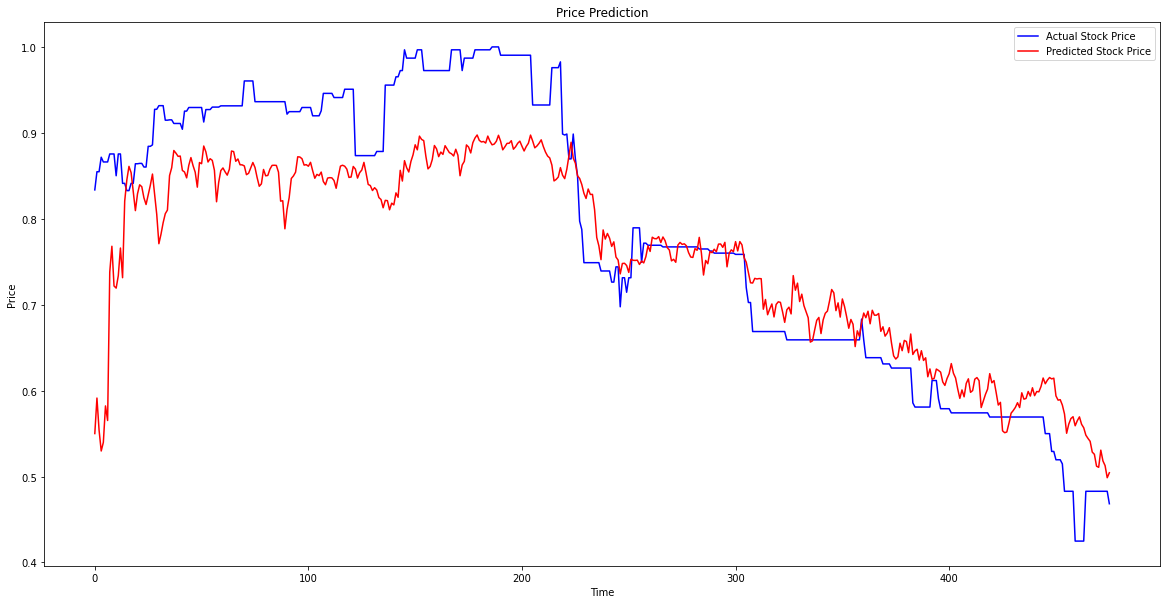

In [106]:
testY_test = np.delete(testY, np.s_[1:a], axis=1)
predicted_price_test_test = np.delete(predicted_price_test, np.s_[1:a], axis=1)

testY_test = np.reshape(testY_test, (476, 1))
predicted_price_test_test = np.reshape(predicted_price_test_test, (476, 1))
print(testY_test.shape)
print(predicted_price_test_test.shape)

plt.figure(figsize=(20,10))
plt.plot(testY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_test_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [108]:
predicted_price_test_test = np.reshape(predicted_price_test_test, (476, ))
predicted_price_test_test = scaler_target.inverse_transform(predicted_price_test_test.reshape(-1,1))

print(predicted_price_test_test, predicted_price_test_test.shape)

testY_test = scaler_target.inverse_transform(testY_test.reshape(-1,1))

print(testY_test, testY_test.shape)

[[48373.246]
 [49596.082]
 [48489.754]
 [47773.344]
 [48070.156]
 [49325.29 ]
 [48823.406]
 [53933.223]
 [54822.562]
 [53454.902]
 [53381.547]
 [53809.508]
 [54761.53 ]
 [53739.645]
 [56377.227]
 [57107.742]
 [57572.62 ]
 [57355.914]
 [56716.043]
 [56049.477]
 [56629.69 ]
 [56938.535]
 [56871.934]
 [56488.508]
 [56260.043]
 [56588.016]
 [56923.58 ]
 [57308.117]
 [56627.195]
 [55918.883]
 [54909.39 ]
 [55240.195]
 [55634.82 ]
 [55943.566]
 [56067.094]
 [57256.465]
 [57526.285]
 [58119.035]
 [58026.758]
 [57917.547]
 [57928.348]
 [57432.367]
 [57379.438]
 [57177.105]
 [57607.953]
 [57875.6  ]
 [57598.938]
 [57373.39 ]
 [56856.836]
 [57705.395]
 [57664.613]
 [58273.46 ]
 [58072.633]
 [57723.016]
 [57836.223]
 [57779.516]
 [57438.76 ]
 [56354.36 ]
 [57022.16 ]
 [57427.37 ]
 [57518.633]
 [57385.38 ]
 [57271.1  ]
 [57472.65 ]
 [58101.035]
 [58081.7  ]
 [57748.195]
 [57828.023]
 [57628.652]
 [57624.24 ]
 [57588.54 ]
 [57286.97 ]
 [57333.87 ]
 [57524.44 ]
 [57706.324]
 [57534.11 ]
 [57186.39 ]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


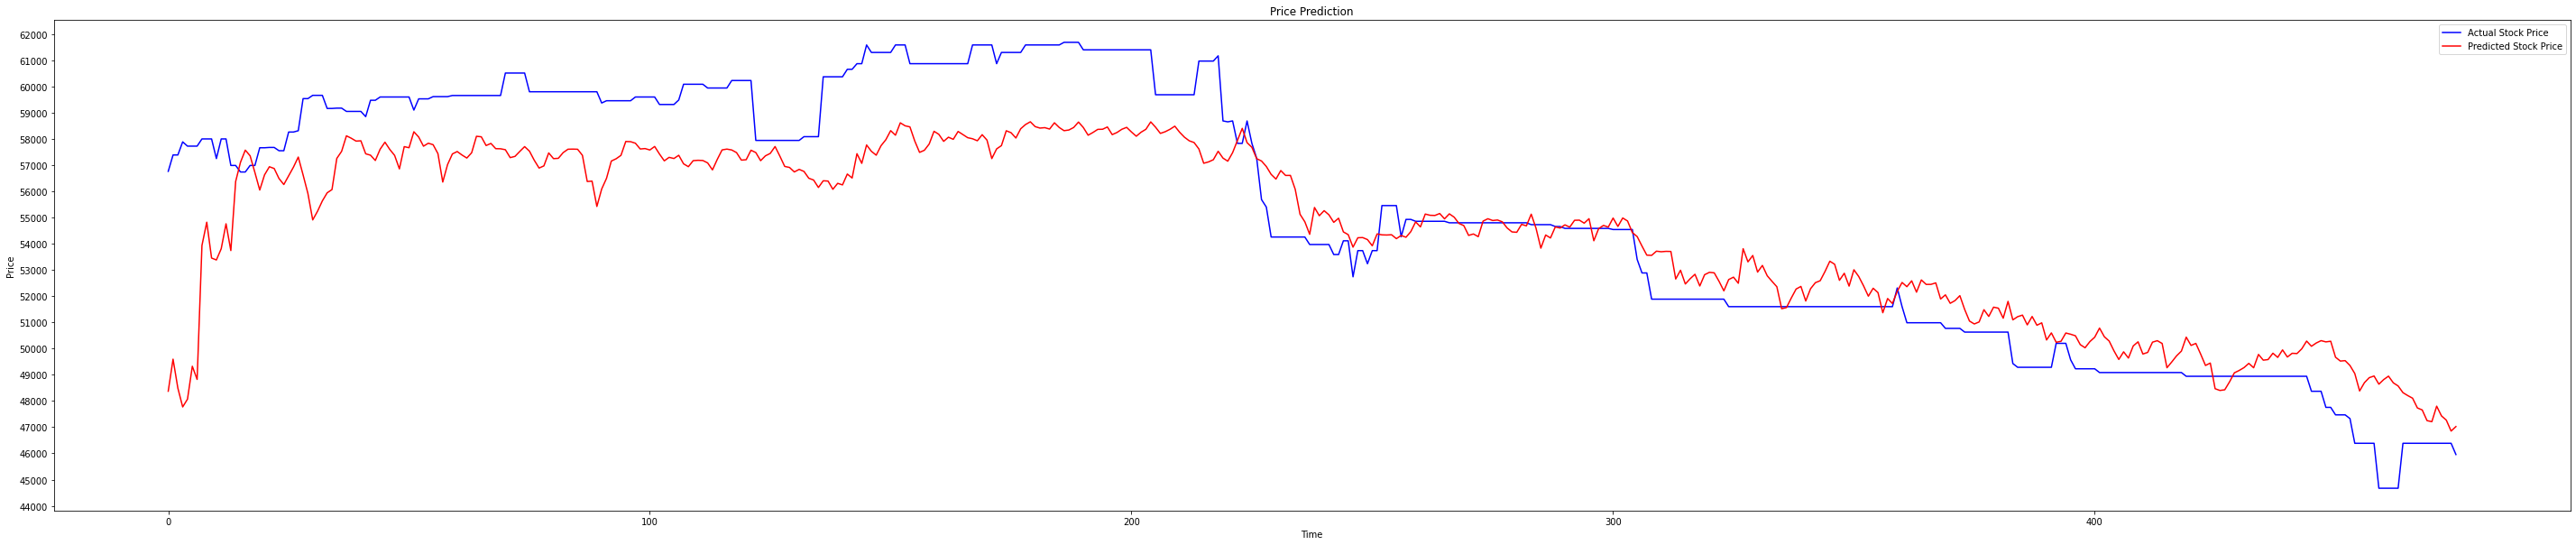

In [109]:
plt.figure(figsize=(50,10))
plt.plot(testY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_test_test, color = 'red', label = 'Predicted Stock Price')

ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))

plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

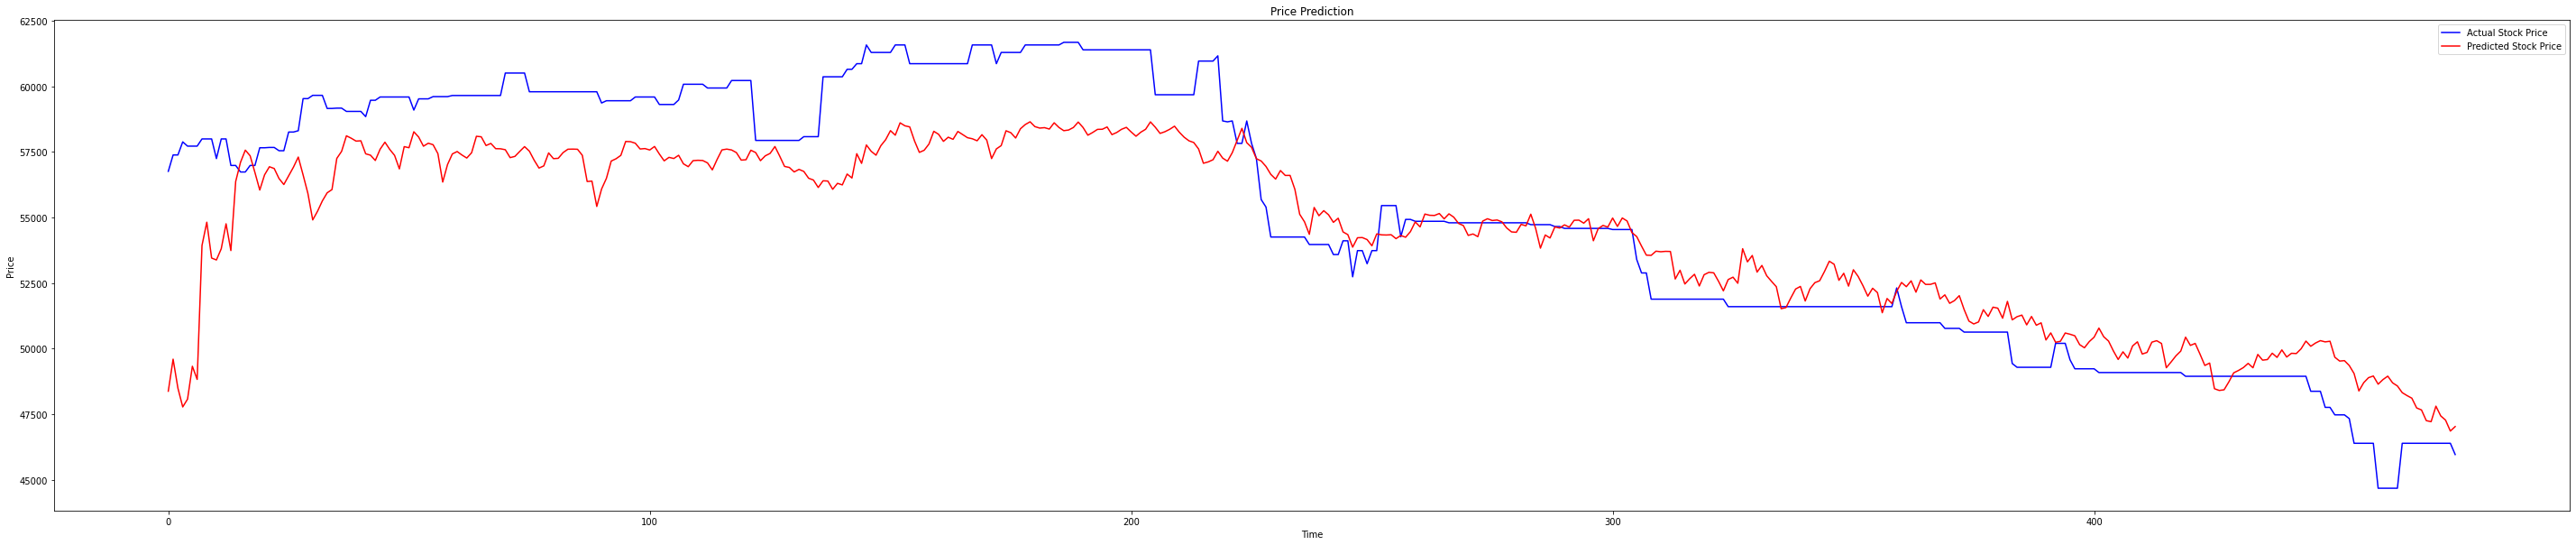

In [110]:
plt.figure(figsize=(50,10))
plt.plot(testY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_test_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [111]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(testY_test, predicted_price_test_test) 
np.sqrt(MSE)

2299.868128425883

In [112]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(testY_test, predicted_price_test_test)

1786.3184004070376

예측방법

In [113]:
minX1 = np.array(dataX[0:7])
minX2 = np.array(dataX[0:8])
minX3 = np.array(dataX[0:2380])
minX4 = np.array(dataX[0:train_size])

In [114]:
predicted_price_min1 = model.predict(minX1, batch_size=a, verbose=1)
predicted_price_min2 = model.predict(minX2, batch_size=a, verbose=1) 
predicted_price_min3 = model.predict(minX3, batch_size=a, verbose=1)
predicted_price_min4 = model.predict(minX4, batch_size=a, verbose=1) 

204/204 [==============================] - 1s 2ms/step


In [115]:
predicted_price_min1[0]

array([[0.48515505],
       [0.4817613 ],
       [0.47928956],
       [0.48169646],
       [0.4798974 ],
       [0.47687632],
       [0.4739542 ]], dtype=float32)

In [116]:
predicted_price_min2[0]

array([[0.47402796],
       [0.4678072 ],
       [0.46776146],
       [0.46782738],
       [0.46895152],
       [0.46831125],
       [0.46322602]], dtype=float32)

In [117]:
predicted_price_min3[0]

array([[0.46225756],
       [0.45585722],
       [0.4581593 ],
       [0.4574445 ],
       [0.46009022],
       [0.4608909 ],
       [0.4546368 ]], dtype=float32)

In [118]:
scaler_target.inverse_transform(predicted_price_min4[0].reshape(-1,1))

array([[46453.8  ],
       [46353.39 ],
       [46280.26 ],
       [46351.473],
       [46298.242],
       [46208.863],
       [46122.41 ]], dtype=float32)